1. PM2.5, PM10 représentent PM1
2. SO2 représnete O2
3. l'humidité, CO représente dewpt
4. O3 représente CO2   CO2 représente TVOC

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\google\auth\crypt\_cryptography_rsa.py:22: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  import cryptography.exceptions


Importer des données

2023-06-24 01:59:10 - 2023-07-11 10:49:42
"09 July 2023:	Measurement error with regard to fine dust values due to sudden increase in air humidity"
Nous supprimons les données contenant des informations postérieures au 9 juillet

In [2]:

data=pd.read_csv("../one_room_apartement.csv")

In [3]:
data.head()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
0,1.995,20.863,6.004,273.935,1.726,23.718,805.0,490.458,1868,518.956,...,758.0,27.774,0.923,26.690,60.385,0.04,12.983,51.839,5.402,859.499
1,1.689,20.863,6.891,296.490,1.726,23.715,806.0,490.505,1867,520.396,...,715.0,27.762,0.739,26.594,60.377,0.03,12.980,52.092,6.451,932.282
2,2.854,20.863,7.486,268.740,1.726,23.716,808.0,489.080,1857,520.139,...,742.0,27.764,3.002,26.501,60.358,0.00,12.977,51.313,6.107,851.850
3,1.635,20.862,5.874,262.821,1.726,23.719,807.0,488.189,1881,518.782,...,746.0,27.748,1.287,26.611,60.426,0.03,12.993,53.420,5.489,829.355
4,1.579,20.864,7.068,297.597,1.725,23.712,809.0,485.401,1880,516.398,...,717.0,27.760,0.527,26.681,60.435,0.03,12.990,52.284,6.723,926.864


In [4]:
data.tail()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
12441,2.493,20.842,3.159,139.359,1.578,27.999,738.0,432.277,1799,715.633,...,661.0,32.491,0.652,30.628,47.086,0.00,12.860,59.537,2.733,432.119
12442,2.550,20.843,2.592,151.838,1.577,28.029,738.0,433.938,1782,723.661,...,653.0,32.507,0.590,30.105,47.237,0.08,12.923,59.008,2.277,475.226
12443,2.020,20.840,3.614,163.927,1.575,28.074,741.0,435.733,1804,733.135,...,650.0,32.559,1.847,29.544,47.292,0.31,12.970,59.580,3.254,520.100
12444,2.970,20.841,2.830,130.268,1.573,28.110,746.0,432.326,1799,739.224,...,654.0,32.575,1.636,29.012,47.268,0.36,12.989,59.275,2.154,408.629
12445,5.349,20.840,3.612,122.472,1.573,28.149,745.0,433.729,1786,747.578,...,648.0,32.597,3.106,28.614,47.254,0.23,13.013,59.092,1.747,381.507


Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [5]:
print(data)

       TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      1.995  20.863  6.004  273.935  1.726       23.718        805.0   
1      1.689  20.863  6.891  296.490  1.726       23.715        806.0   
2      2.854  20.863  7.486  268.740  1.726       23.716        808.0   
3      1.635  20.862  5.874  262.821  1.726       23.719        807.0   
4      1.579  20.864  7.068  297.597  1.725       23.712        809.0   
...      ...     ...    ...      ...    ...          ...          ...   
12441  2.493  20.842  3.159  139.359  1.578       27.999        738.0   
12442  2.550  20.843  2.592  151.838  1.577       28.029        738.0   
12443  2.020  20.840  3.614  163.927  1.575       28.074        741.0   
12444  2.970  20.841  2.830  130.268  1.573       28.110        746.0   
12445  5.349  20.840  3.612  122.472  1.573       28.149        745.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      490.458         1868  518.956  ...   758

In [6]:
nan_rows_count = data.isna().any(axis=1).sum()

print(f"\n Le nombre de lignes contenant des valeurs NaN est de: {nan_rows_count}")


 Le nombre de lignes contenant des valeurs NaN est de: 0


**Nettoyage des données**

Supprimer les lignes Nan et les colonnes de caractéristiques inintéressantes

'pm1','oxygen','tvoc','co2','dewpt'

In [7]:
data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','humidity_abs','dHdt','cnt0_3'], axis=1, inplace=True)
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

Nous supprimons les données contenant des informations postérieures au 9 juillet

"température", "pression", "humidité" à la fin des colonnes de données

In [8]:
dates_to_remove = ['2023-07-09','2023-07-10','2023-07-11']
dates_to_remove = pd.to_datetime(dates_to_remove)
data = data[~data['timestamp'].dt.normalize().isin(dates_to_remove)]
columns = list(data.columns)
columns_to_move = ['pm1', 'oxygen', 'tvoc', 'co2', 'dewpt']
columns_to_keep_at_end = ['temperature', 'pressure', 'humidity']
for col in columns_to_move + columns_to_keep_at_end:
    columns.remove(col)
columns = columns_to_move + columns + columns_to_keep_at_end
data = data[columns]

Modifier le nom de timestamp et le convertir en index

In [9]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.tail(10))

                        pm1  oxygen     tvoc      co2   dewpt    pm10     co  \
date                                                                           
2023-07-08 23:40:25  10.375  20.771  1660.24  484.797  17.376  14.125  1.626   
2023-07-08 23:42:24  10.686  20.771  1661.65  485.178  17.364  13.626  1.625   
2023-07-08 23:44:25  11.233  20.776  1707.57  488.142  17.369  16.510  1.624   
2023-07-08 23:46:25  11.883  20.778  1658.70  486.802  17.365  17.540  1.621   
2023-07-08 23:48:26  12.278  20.778  1611.52  486.528  17.372  18.675  1.619   
2023-07-08 23:50:26  11.941  20.778  1522.43  485.832  17.363  15.895  1.616   
2023-07-08 23:52:25  12.091  20.778  1393.73  486.623  17.372  17.712  1.613   
2023-07-08 23:54:26  11.641  20.778  1451.10  487.518  17.380  15.942  1.611   
2023-07-08 23:56:28  11.238  20.778  1572.35  490.148  17.351  15.670  1.609   
2023-07-08 23:58:27  12.237  20.776  1696.76  493.541  17.388  18.649  1.607   

                         so2     no2   

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

In [10]:
values = data.values
print(values.shape[1])

15


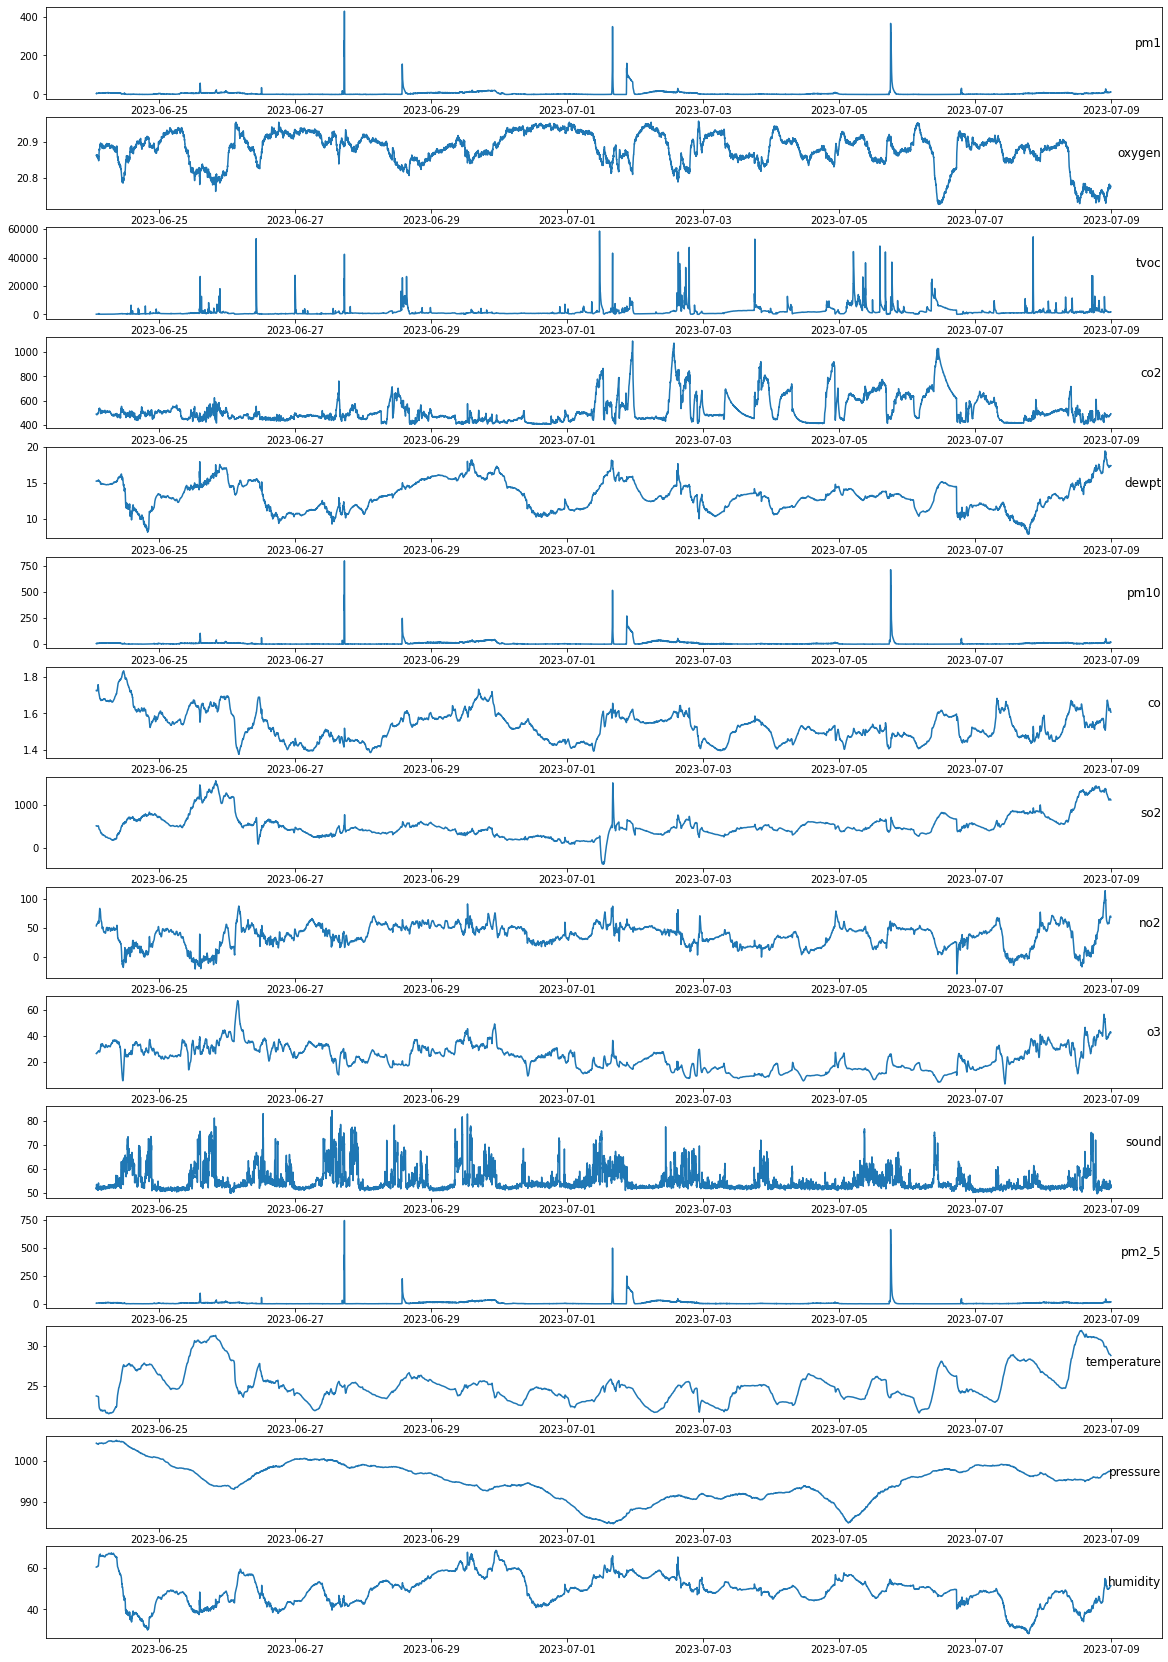

In [11]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9, 10, 11, 12, 13, 14]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

**Multivariate LSTM Predictive Modeling**

'pm1','oxygen','tvoc','co2','dewpt'     7,1,9,4,8

In [12]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


Les données de la série temporelle sont converties en données d'apprentissage supervisé et des étiquettes sont générées. Les variables d'entrée sont ensuite normalisées. Compte tenu des mesures de la pollution et des conditions météorologiques de l'heure précédente (t-1), nous posons le problème de l'apprentissage supervisé pour prédire la concentration de la pollution à l'heure actuelle (t).

In [13]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [14]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.drop(reframed.columns[[0, 1, 2, 3, 4]], axis=1, inplace=True)
reframed.head()

,var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
1,0.007486,0.763676,0.459352,0.577556,0.365211,0.068824,0.007231,0.213425,0.966908,0.798549,...,0.001491,0.121795,0.636977,0.008592,0.763676,0.460102,0.586407,0.363713,0.076055,0.008636
2,0.008592,0.763676,0.460102,0.586407,0.363713,0.076055,0.008636,0.213135,0.965919,0.798350,...,0.001670,0.119705,0.636631,0.009334,0.763676,0.459968,0.592357,0.362262,0.053790,0.008175
3,0.009334,0.763676,0.459968,0.592357,0.362262,0.053790,0.008175,0.213232,0.964931,0.797876,...,0.001553,0.118399,0.638362,0.007324,0.763676,0.459262,0.594817,0.363978,0.114010,0.007348
4,0.007324,0.763676,0.459262,0.594817,0.363978,0.114010,0.007348,0.213521,0.963943,0.799571,...,0.001449,0.114310,0.638016,0.008813,0.761488,0.458021,0.596183,0.365070,0.081542,0.009000
5,0.008813,0.761488,0.458021,0.596183,0.365070,0.081542,0.009000,0.212846,0.962955,0.799795,...,0.001466,0.112774,0.637930,0.008857,0.759300,0.457025,0.597494,0.367301,0.067623,0.007897


80% train - 20% test
Ligne de départ de l'ensemble de données de test = train_x.shape[0]+1(onglet)+x(projetée)+1(test)
（2023-06-24 02:01:10<3> - 2023-07-06 00:18:22<8559>）         （2023-07-06 00:20:20<8560> - 2023-07-08 23:58:27<10698>）

In [15]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)
train = reframed.iloc[:train_samples, :]
test = reframed.iloc[train_samples:, :]

train_X, train_y = train.iloc[:, :-12].values, train.iloc[:, -12:].values
test_X, test_y = test.iloc[:, :-12].values, test.iloc[:, -12:].values

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8557, 1, 10) (8557, 12) (2139, 1, 10) (2139, 12)


Define the GRU model

Il y a 50 neurones dans la première couche cachée et 11 neurones dans la couche de sortie pour prédire la concentration de pollution. La dimension des données d'entrée sera de 1 pas de temps (c'est-à-dire 2 secondes) et de 14 caractéristiques.

In [16]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')
print(model.summary())
# model = Sequential()
# model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(11))
# model.compile(optimizer='adam', loss='mae')
# model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                9300      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 12)                612       
Total params: 9,912
Trainable params: 9,912
Non-trainable params: 0
_________________________________________________________________
None


Training the GRU model

Epoch 1/500
29/29 - 1s - loss: 0.2130 - val_loss: 0.1411
Epoch 2/500
29/29 - 0s - loss: 0.1236 - val_loss: 0.1042
Epoch 3/500
29/29 - 0s - loss: 0.1076 - val_loss: 0.1008
Epoch 4/500
29/29 - 0s - loss: 0.1012 - val_loss: 0.0962
Epoch 5/500
29/29 - 0s - loss: 0.0958 - val_loss: 0.0931
Epoch 6/500
29/29 - 0s - loss: 0.0915 - val_loss: 0.0897
Epoch 7/500
29/29 - 0s - loss: 0.0876 - val_loss: 0.0872
Epoch 8/500
29/29 - 0s - loss: 0.0843 - val_loss: 0.0844
Epoch 9/500
29/29 - 0s - loss: 0.0809 - val_loss: 0.0814
Epoch 10/500
29/29 - 0s - loss: 0.0776 - val_loss: 0.0785
Epoch 11/500
29/29 - 0s - loss: 0.0745 - val_loss: 0.0756
Epoch 12/500
29/29 - 0s - loss: 0.0722 - val_loss: 0.0731
Epoch 13/500
29/29 - 0s - loss: 0.0694 - val_loss: 0.0706
Epoch 14/500
29/29 - 0s - loss: 0.0668 - val_loss: 0.0678
Epoch 15/500
29/29 - 0s - loss: 0.0649 - val_loss: 0.0655
Epoch 16/500
29/29 - 0s - loss: 0.0629 - val_loss: 0.0637
Epoch 17/500
29/29 - 0s - loss: 0.0611 - val_loss: 0.0625
Epoch 18/500
29/29 - 0s

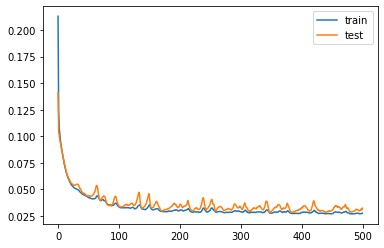

In [17]:
history = model.fit(train_X, train_y, epochs=500, batch_size=300, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Evaluating GRU models

Les prédictions de sortie sont obtenues grâce au modèle, puis les valeurs réelles sont obtenues à partir des données d'origine.

In [18]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
selected_columns = [i for i in range(test_X.shape[1]) if i in [7, 8, 9]]
# selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [3, 10, 11]]
inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:-3]
# oxygen_predict = inv_yhat[:, 0]
# pm10_predict = inv_yhat[:, 1]
# co_predict = inv_yhat[:, 2]
# co2_predict = inv_yhat[:, 3]
# so2_predict = inv_yhat[:, 4]
# no2_predict = inv_yhat[:, 5]
# pm1_predict = inv_yhat[:, 6]
# dewpt_predict = inv_yhat[:, 7]
# tvoc_predict = inv_yhat[:, 8]
# pm2_5_predict = inv_yhat[:, 9]

test_y = test_y.reshape((len(test_y), train_y.shape[1]))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())
# oxygen_reel = inv_y[:, 0]
# pm10_reel = inv_y[:, 1]
# co_reel = inv_y[:, 2]
# co2_reel = inv_y[:, 3]
# so2_reel = inv_y[:, 4]
# no2_reel = inv_y[:, 5]
# pm1_reel = inv_y[:, 6]
# dewpt_reel = inv_y[:, 7]
# tvoc_reel = inv_y[:, 8]
# pm2_5_reel = inv_y[:, 9]

# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)


      0          1            2           3          4      5      6   \
0  0.326  20.881001  1159.930054  661.971008  12.763999  1.002  1.479   
1  0.069  20.881001  1146.650024  651.153992  12.744000  0.485  1.479   
2  0.252  20.879999  1146.369995  653.598999  12.749000  0.378  1.478   
3  0.438  20.879999  1163.060059  665.013977  12.745001  0.836  1.478   
4  0.465  20.879000  1190.010010  668.629028  12.740999  0.734  1.478   

           7          8       9          10     11  
0  438.337982  47.824005  15.432  52.966000  0.699  
1  437.725983  47.506008  15.361  52.457001  0.118  
2  435.914001  47.601002  15.342  52.323002  0.336  
3  435.846954  47.555004  15.323  51.528999  0.527  
4  436.254974  47.664001  15.343  51.537998  0.502  


Afficher valeur pic sur tvoc

Comme je veux trouver la relation entre les paramètres, je vais choisir des valeurs de pic pour découvrir la relation entre les paramètres. Mais cela semble lourd et difficile à observer, nous utilisons la méthode de la carte thermique pour y parvenir.

In [19]:
# col_index = 8
# col_values = inv_y_df.iloc[:, col_index]

# filtered_rows = col_values[col_values > 8000]
# date_indices = filtered_rows.index + train_X.shape[0] + 1
# datepic = data.iloc[date_indices, col_index]
# for index, value in filtered_rows.items():
#     print(f"nb de ligne: {index}, valeur: {value}, dates: {datepic}\n")

Comparaison des valeurs prédites et des valeurs réelles pour 12 valeurs de sortie

In [20]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


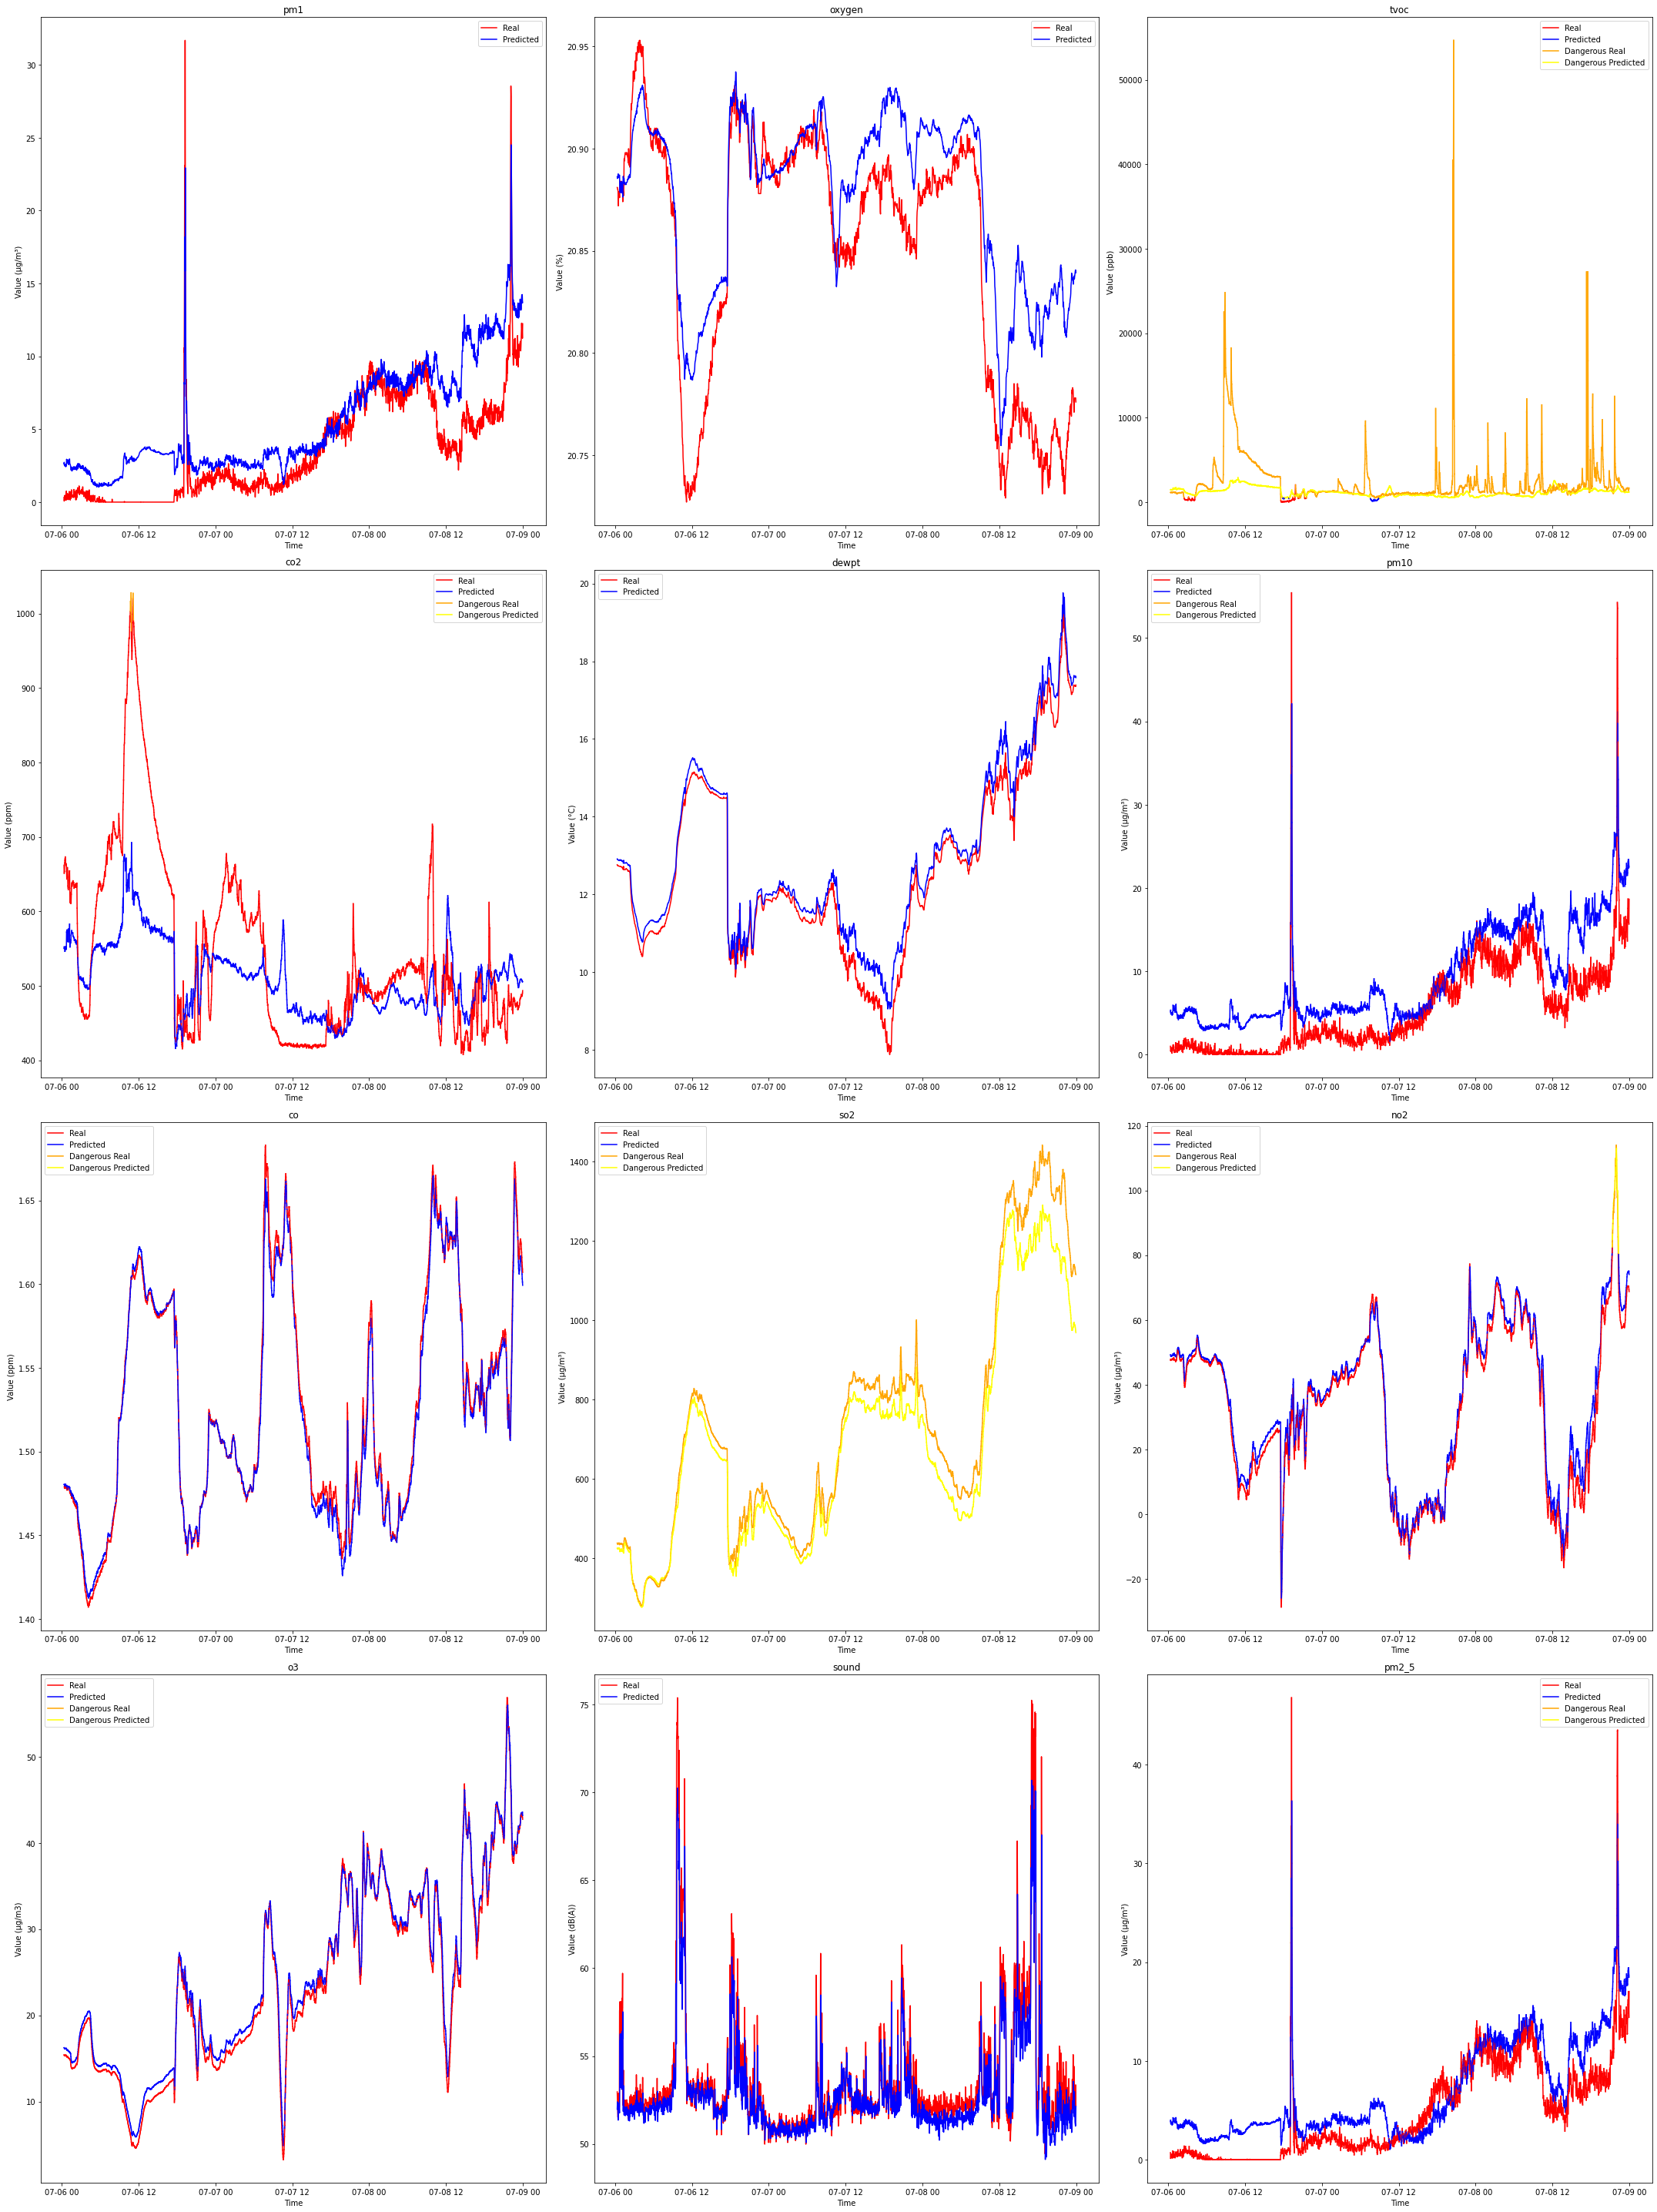

In [21]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'pm1': 0, 'oxygen': 1, 'tvoc': 2, 'co2': 3, 'dewpt': 4, 
    'pm10': 5, 'co': 6, 'so2': 7, 'no2': 8, 'o3' : 9,
    'sound': 10, 'pm2_5': 11
}

feature_units = {
    'pm1': 'µg/m³', 'oxygen': '%', 'tvoc': 'ppb',
    'co2': 'ppm',  'dewpt': '°C', 'pm10': 'µg/m³', 'co': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³',
    'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

Calcul de l'RMSE(Root Mean Square Error)

In [22]:

print(inv_y.shape, inv_yhat.shape)
selected_columns2 = [i for i in range(test_y.shape[1]) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
feature_names = ['pm1','oxygen','tvoc','co2','dewpt', 'pm10', 'co', 'so2', 'no2', 'o3' ,'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    # # Avoid division by zero for MAPE
    # actual_values = inv_y[:, i]
    # predicted_values = inv_yhat[:, i]
    # # Replace zeros in actual values with a small number (1e-10)
    # actual_values = np.where(actual_values == 0, 1e-10, actual_values)
    # mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    print(f'Test RMSE for {feature}: {rmse:.3f}')
    # print(f'Rest MAPE for {feature}: {mape:.3f}%')

(2139, 12) (2139, 12)
Test RMSE for pm1: 2.711
Test RMSE for oxygen: 0.036
Test RMSE for tvoc: 3263.782
Test RMSE for co2: 92.777
Test RMSE for dewpt: 0.463
Test RMSE for pm10: 4.523
Test RMSE for co: 0.006
Test RMSE for so2: 66.700
Test RMSE for no2: 3.557
Test RMSE for o3: 1.016
Test RMSE for sound: 1.615
Test RMSE for pm2_5: 2.979


In [23]:
# iaqi_condition_withouto3 = lambda x: (x[:, 6] <= 10) & (x[:, 11] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300)
# iaqi_condition = lambda x: (x[:, 6] <= 10) & (x[:, 10] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300) & (x[:, 9] < 18)
# inv_y_iaq = iaqi_condition_withouto3(inv_y).astype(int)
# inv_yhat_iaq = iaqi_condition_withouto3(inv_yhat).astype(int)
# inv_y_iaq2 = iaqi_condition(inv_y).astype(int)
# inv_yhat_iaq2 = iaqi_condition(inv_yhat).astype(int)

# inv_y = np.hstack((inv_y, inv_y_iaq.reshape(-1, 1)))
# inv_yhat = np.hstack((inv_yhat, inv_yhat_iaq.reshape(-1, 1)))
# inv_y2 = np.hstack((inv_y, inv_y_iaq2.reshape(-1, 1)))
# inv_yhat2 = np.hstack((inv_yhat, inv_yhat_iaq2.reshape(-1, 1)))

In [24]:
# print("inv_y:\n", inv_y)
# print("inv_yhat:\n", inv_yhat)

PM2.5 (Particulate Matter 2.5-micrometer)

PM2.5 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [25]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

PM10 (Particulate Matter 10-micrometer)

PM10 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [26]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 5]
inv_y_PM10_values = inv_y[:, 5]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

SO2 (Sulphur Dioxide)

SO2 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [27]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 7]
inv_y_SO2_values = inv_y[:, 7]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

NO2 (Any Nitric x-oxide)

NO2 is measured in ppb (parts per billion). The predefined groups are defined in the function below:

In [28]:
## NO2 Sub-Index calculation
def ugm3_to_ppb(no2_ugm3):
    MW_NO2 = 46.0055  # g/mol
    standard_volume = 24.45  # L/mol
    return (no2_ugm3 * standard_volume) / MW_NO2

def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 8]
inv_y_NO2_values = inv_y[:, 8]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

CO (Carbon Monoxide)

CO is measured in mg / m3 (milligrams per cubic meter of air). The predefined groups are defined in the function below:

In [29]:
def ppm_to_mgm3(co_ppm):
    MW_CO = 28.01  # g/mol
    standard_volume = 24.45  # L/mol
    return co_ppm * MW_CO / standard_volume
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 6]
inv_y_CO_values = inv_y[:, 6]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

O3 (Ozone or Trioxygen)

O3 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [30]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

AQI

The final AQI is the maximum Sub-Index among the available sub-indices with the condition that at least one of PM2.5 and PM10 should be available and at least three out of the seven should be available.

There is no theoretical upper value of AQI but its rare to find values over 1000.

In [31]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

       col0       col1         col2        col3       col4      col5  \
0  2.623049  20.886206  1476.925049  550.109741  12.913818  5.108290   
1  2.731889  20.885397  1499.033691  552.223389  12.910867  5.324099   
2  2.495314  20.886278  1474.124268  549.966187  12.889566  4.879404   
3  2.515026  20.886448  1473.851074  549.632141  12.892230  4.909895   
4  2.586107  20.887575  1451.276489  546.382385  12.887451  5.009334   

       col6        col7       col8       col9  ...     col11     col12  \
0  1.480234  425.449707  49.249813  16.250170  ...  3.821351  6.368918   
1  1.480202  424.833374  49.079964  16.220032  ...  3.981884  6.636474   
2  1.480296  425.001190  48.736382  16.152725  ...  3.610234  6.017057   
3  1.479382  423.493530  48.841736  16.134920  ...  3.648311  6.080519   
4  1.479536  424.322723  48.753757  16.119724  ...  3.785506  6.309177   

      col13       col14      col15      col16      col17  AQI_calculated  \
0  5.108290  210.821359  32.717771  84.788027 

In [32]:

from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.863487611033193


In [33]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 


1847


anticiper

In [34]:
# 7*2 = 14 min
n_temps = 7
n_features = 15

reframed = series_to_supervised(scaled, n_temps, 1)

In [35]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.drop(reframed.columns[[0, 1, 2, 3, 4]], axis=1, inplace=True)
reframed.head(10)

,var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),var11(t-7),var12(t-7),var13(t-7),var14(t-7),var15(t-7),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
7,0.007486,0.763676,0.459352,0.577556,0.365211,0.068824,0.007231,0.213425,0.966908,0.798549,...,0.001476,0.115279,0.638189,0.008789,0.757112,0.454809,0.596099,0.370624,0.079570,0.008455
8,0.008592,0.763676,0.460102,0.586407,0.363713,0.076055,0.008636,0.213135,0.965919,0.798350,...,0.001593,0.115752,0.639488,0.009619,0.759300,0.454247,0.596541,0.373339,0.056076,0.009624
9,0.009334,0.763676,0.459968,0.592357,0.362262,0.053790,0.008175,0.213232,0.964931,0.797876,...,0.001630,0.119245,0.640353,0.008591,0.761488,0.454146,0.598910,0.373994,0.078770,0.008112
10,0.007324,0.763676,0.459262,0.594817,0.363978,0.114010,0.007348,0.213521,0.963943,0.799571,...,0.002238,0.119999,0.639314,0.009048,0.761488,0.454584,0.599891,0.374384,0.068967,0.009314
11,0.008813,0.761488,0.458021,0.596183,0.365070,0.081542,0.009000,0.212846,0.962955,0.799795,...,0.003386,0.121418,0.640180,0.007789,0.768053,0.455741,0.601804,0.376053,0.074111,0.008089
12,0.008857,0.759300,0.457025,0.597494,0.367301,0.067623,0.007897,0.212171,0.961475,0.800369,...,0.003392,0.125503,0.640613,0.009407,0.772429,0.456684,0.604957,0.379095,0.056819,0.009522
13,0.008218,0.759300,0.455760,0.596975,0.369095,0.058020,0.008322,0.212171,0.960484,0.800419,...,0.003172,0.123783,0.640959,0.008095,0.776805,0.457308,0.607487,0.381638,0.062364,0.008471
14,0.008789,0.757112,0.454809,0.596099,0.370624,0.079570,0.008455,0.212267,0.959991,0.800543,...,0.002926,0.132610,0.643988,0.009595,0.781182,0.457578,0.611405,0.383354,0.045587,0.009887
15,0.009619,0.759300,0.454247,0.596541,0.373339,0.056076,0.009624,0.212075,0.959003,0.802189,...,0.002631,0.134140,0.644854,0.009814,0.783370,0.457142,0.614481,0.385710,0.059049,0.009942
16,0.008591,0.761488,0.454146,0.598910,0.373994,0.078770,0.008112,0.212075,0.958511,0.803161,...,0.002414,0.131066,0.644421,0.009958,0.792123,0.457181,0.616324,0.387675,0.071653,0.010300


In [36]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_temps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8557, 105) (8557, 12) (2133, 105) (2133, 12)


In [37]:
train_X = train_X.reshape((train_X.shape[0], n_temps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_temps, n_features))

print(test_X.shape,train_X.shape)

(2133, 7, 15) (8557, 7, 15)


In [38]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                612       
Total params: 10,662
Trainable params: 10,662
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/400
119/119 - 1s - loss: 0.1430 - val_loss: 0.0898
Epoch 2/400
119/119 - 0s - loss: 0.0919 - val_loss: 0.0718
Epoch 3/400
119/119 - 0s - loss: 0.0724 - val_loss: 0.0601
Epoch 4/400
119/119 - 0s - loss: 0.0608 - val_loss: 0.0538
Epoch 5/400
119/119 - 0s - loss: 0.0534 - val_loss: 0.0459
Epoch 6/400
119/119 - 0s - loss: 0.0484 - val_loss: 0.0411
Epoch 7/400
119/119 - 0s - loss: 0.0450 - val_loss: 0.0390
Epoch 8/400
119/119 - 1s - loss: 0.0419 - val_loss: 0.0370
Epoch 9/400
119/119 - 0s - loss: 0.0401 - val_loss: 0.0330
Epoch 10/400
119/119 - 0s - loss: 0.0368 - val_loss: 0.0311
Epoch 11/400
119/119 - 0s - loss: 0.0351 - val_loss: 0.0302
Epoch 12/400
119/119 - 0s - loss: 0.0336 - val_loss: 0.0270
Epoch 13/400
119/119 - 0s - loss: 0.0330 - val_loss: 0.0263
Epoch 14/400
119/119 - 0s - loss: 0.0326 - val_loss: 0.0275
Epoch 15/400
119/119 - 0s - loss: 0.0321 - val_loss: 0.0268
Epoch 16/400
119/119 - 0s - loss: 0.0317 - val_loss: 0.0277
Epoch 17/400
119/119 - 0s - loss: 0.0322 - val_lo

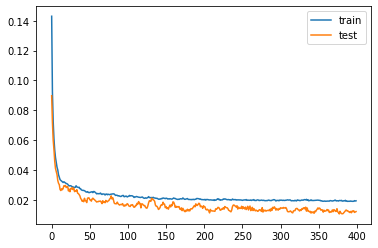

In [39]:
history = model.fit(train_X, train_y, epochs=400, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [40]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_temps*n_features))

selected_columns = [i for i in range(test_y.shape[1]) if i in [7,8,9]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:-3]
# inv_yhat = inv_yhat[:, selected_columns2]

test_y = test_y.reshape(len(test_y), test_y.shape[1])
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

      0          1            2           3       4      5      6   \
0  0.314  20.875999  1169.959961  673.091980  12.733  0.494  1.478   
1  0.128  20.877001  1145.729980  669.117004  12.730  0.174  1.479   
2  0.289  20.877001  1137.619995  663.067993  12.728  0.389  1.478   
3  0.502  20.879000  1132.069946  661.744019  12.729  0.780  1.478   
4  0.136  20.878000  1165.359985  663.919983  12.725  0.492  1.478   

           7          8       9          10     11  
0  438.166992  47.861004  15.370  52.881001  0.491  
1  437.809021  47.721004  15.375  52.095001  0.174  
2  437.946014  47.740005  15.366  52.841000  0.389  
3  438.044983  47.889004  15.388  52.228001  0.558  
4  436.010010  47.858002  15.355  52.105000  0.172  


In [41]:
# col_index = 8
# col_values = inv_y_df.iloc[:, col_index]

# date_indices = filtered_rows.index + train_X.shape[0] + 1
# datepic = data.iloc[date_indices, col_index]
# for index, value in filtered_rows.items():
#     print(f"nb de ligne: {index}, valeur: {value}, dates: {datepic}\n")

In [42]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


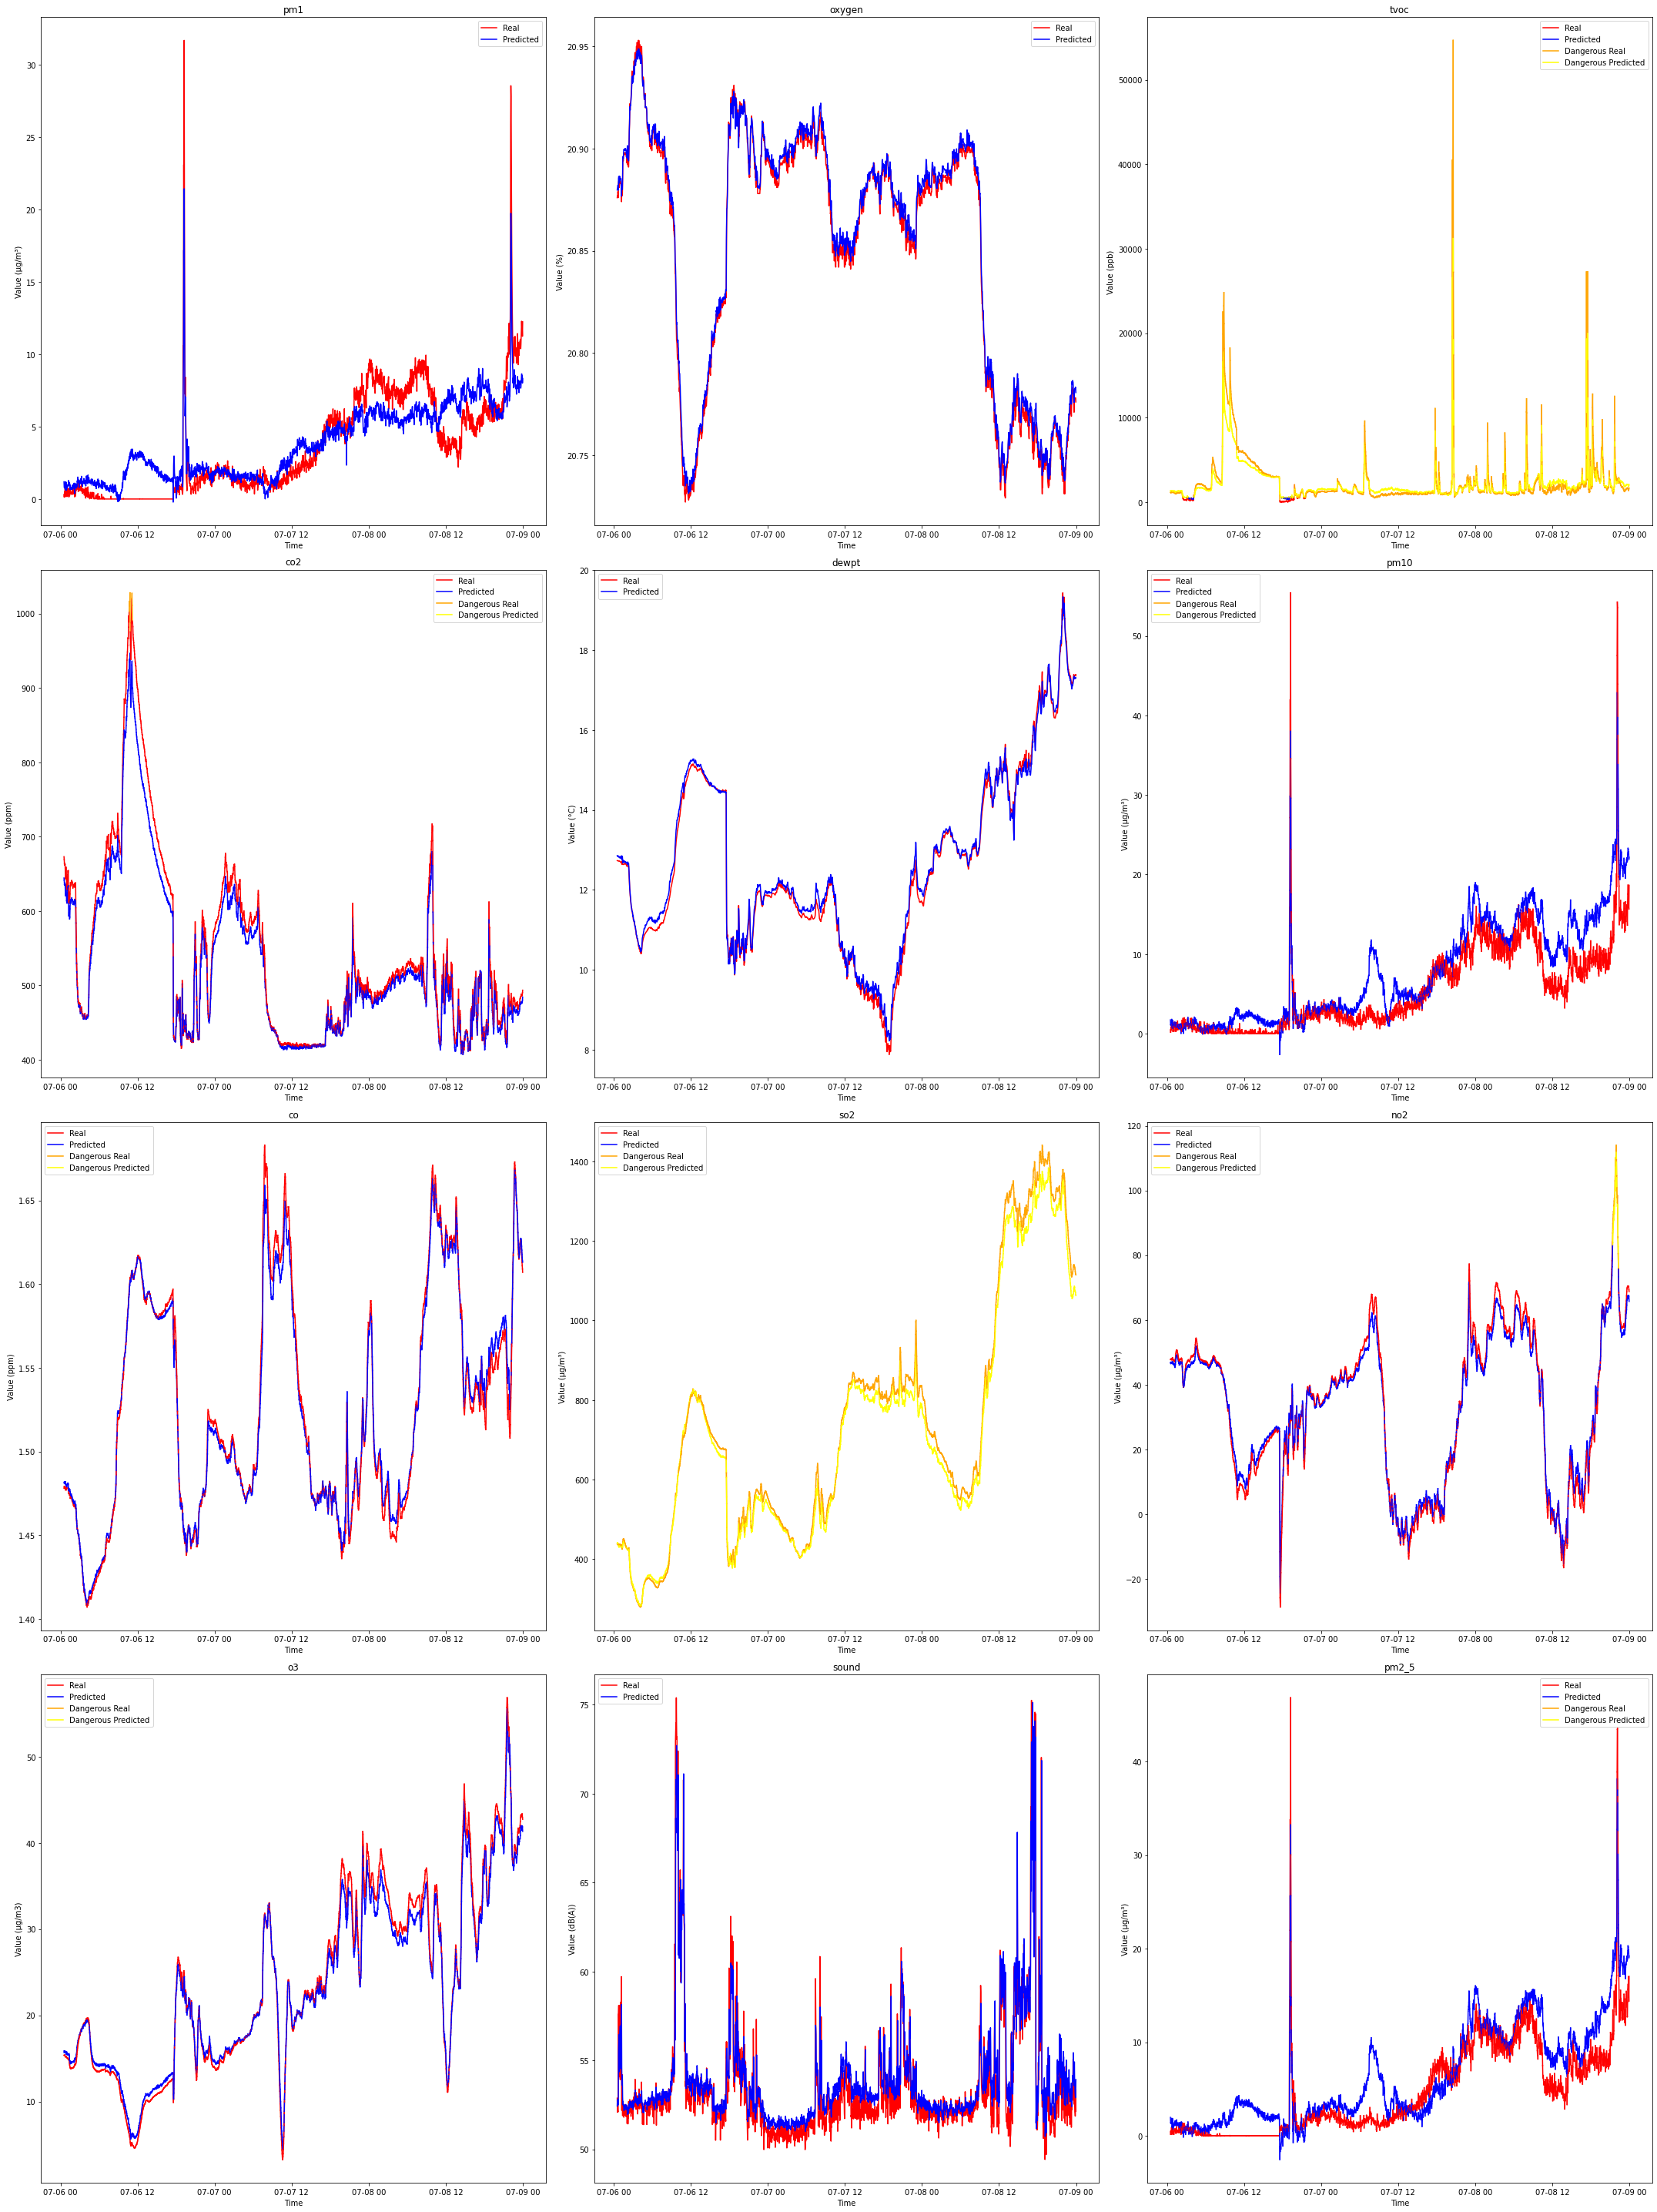

In [43]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'pm1': 0, 'oxygen': 1, 'tvoc': 2, 'co2': 3, 'dewpt': 4, 
    'pm10': 5, 'co': 6, 'so2': 7, 'no2': 8, 'o3' : 9,
    'sound': 10, 'pm2_5': 11
}

feature_units = {
    'pm1': 'µg/m³', 'oxygen': '%', 'tvoc': 'ppb',
    'co2': 'ppm',  'dewpt': '°C', 'pm10': 'µg/m³', 'co': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³',
    'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}


for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()


L'ensemble de tests commence par des données de comptage à la ligne 9393

In [44]:
print(inv_y.shape, inv_yhat.shape)

(2133, 12) (2133, 12)


In [45]:
selected_columns2 = [i for i in range(inv_y.shape[1]) if i not in [12,13,14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]

In [46]:
feature_names = ['pm1','oxygen','tvoc','co2','dewpt', 'pm10', 'co', 'so2', 'no2', 'o3' ,'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    # mape = np.mean(np.abs((inv_y[:, i] - inv_yhat[:, i])/inv_y[:, i]))*100
    print(f'Test RMSE for {feature}: {rmse:.3f}')
    # print(f'Rest MAPE for {feature}: {mape:.3f}%')

Test RMSE for pm1: 1.739
Test RMSE for oxygen: 0.004
Test RMSE for tvoc: 1099.086
Test RMSE for co2: 21.753
Test RMSE for dewpt: 0.170
Test RMSE for pm10: 3.446
Test RMSE for co: 0.007
Test RMSE for so2: 28.772
Test RMSE for no2: 2.534
Test RMSE for o3: 1.126
Test RMSE for sound: 1.509
Test RMSE for pm2_5: 2.763


In [47]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [48]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 5]
inv_y_PM10_values = inv_y[:, 5]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [49]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 7]
inv_y_SO2_values = inv_y[:, 7]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [50]:
## NO2 Sub-Index calculation
def ugm3_to_ppb(no2_ugm3):
    MW_NO2 = 46.0055  # g/mol
    standard_volume = 24.45  # L/mol
    return (no2_ugm3 * standard_volume) / MW_NO2

def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 8]
inv_y_NO2_values = inv_y[:, 8]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [51]:
def ppm_to_mgm3(co_ppm):
    MW_CO = 28.01  # g/mol
    standard_volume = 24.45  # L/mol
    return co_ppm * MW_CO / standard_volume
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 6]
inv_y_CO_values = inv_y[:, 6]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [52]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [53]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

       col0       col1         col2        col3       col4      col5  \
0  1.189401  20.879759  1345.940552  644.373047  12.856454  1.731696   
1  0.812847  20.880735  1343.318726  641.265625  12.838012  1.123498   
2  0.775053  20.881083  1325.343018  635.561646  12.840615  1.057380   
3  0.964954  20.882074  1326.259399  634.842834  12.846004  1.386533   
4  0.736364  20.881454  1348.313965  637.506409  12.844778  1.008947   

       col6        col7       col8       col9  ...     col11     col12  \
0  1.481122  440.205170  46.690666  15.857456  ...  1.981334  3.302223   
1  1.481489  441.542664  46.872845  15.686858  ...  1.421000  2.368333   
2  1.481853  440.555847  46.502079  15.875846  ...  1.345990  2.243317   
3  1.480859  439.342407  46.745228  15.848664  ...  1.630598  2.717663   
4  1.480827  439.284851  46.955437  15.849784  ...  1.308090  2.180151   

      col13       col14      col15      col16      col17  AQI_calculated  \
0  1.731696  214.334564  31.017671  84.838905 

In [54]:
# print("inv_y:\n", inv_y)
# print("inv_yhat:\n", inv_yhat)

In [55]:
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.8462259728082513


In [56]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

1805
